In [1]:
#imports
import numpy as np 
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import OneHotEncoder

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

In [2]:
df = pq.read_table(source="../data/chargecurves_train.parquet").to_pandas()
df.head(20)

,id,timestamp,soc,power,nominal_power,location_id,sub_id
0,1,2023-03-15 09:46:44,42.0,37.73,62.5,0,0
1,1,2023-03-15 09:47:44,44.0,30.10,62.5,0,1
2,1,2023-03-15 09:48:44,46.0,27.46,62.5,0,2
3,1,2023-03-15 09:49:44,49.0,26.42,62.5,0,3
4,1,2023-03-15 09:50:44,51.0,25.46,62.5,0,4
5,1,2023-03-15 09:51:44,53.0,23.55,62.5,0,5
6,1,2023-03-15 09:52:44,55.0,23.63,62.5,0,6
7,1,2023-03-15 09:53:44,56.0,22.46,62.5,0,7
8,1,2023-03-15 09:54:44,58.0,20.93,62.5,0,8
9,1,2023-03-15 09:55:44,60.0,20.18,62.5,0,9


In [3]:
df.isnull().sum()

id                  0
timestamp           0
soc              6081
power            7127
nominal_power       0
location_id         0
sub_id              0
dtype: int64

In [4]:
df.describe()

,id,timestamp,soc,power,nominal_power,location_id,sub_id
count,3.960349e+06,3960349,3.954268e+06,3.953222e+06,3.960349e+06,3.960349e+06,3.960349e+06
mean,6.987936e+04,2023-06-20 17:26:36.712216832,5.714675e+01,4.685585e+01,1.633075e+02,8.677634e+01,1.945163e+01
min,1.000000e+00,2022-01-01 02:42:08,1.000000e+00,0.000000e+00,5.000000e+01,0.000000e+00,0.000000e+00
25%,3.497300e+04,2022-12-13 13:28:22,4.200000e+01,2.864000e+01,6.250000e+01,2.800000e+01,9.000000e+00
50%,6.984200e+04,2023-08-01 12:08:28,5.800000e+01,4.452000e+01,1.700000e+02,7.100000e+01,1.900000e+01
75%,1.048190e+05,2024-01-17 15:48:11,7.300000e+01,5.944000e+01,2.000000e+02,1.290000e+02,2.900000e+01
max,1.400000e+05,2024-06-26 15:22:57,1.040000e+02,2.355480e+03,5.000000e+02,3.450000e+02,3.900000e+01
std,4.039902e+04,NaN,2.049384e+01,2.638718e+01,9.091005e+01,7.068857e+01,1.154053e+01


In [5]:
def reshape_dataframe(df):
    first_timestamps = df.groupby('id')['timestamp'].first().reset_index()

    pivot_df = df.pivot(index=['id', 'nominal_power', 'location_id'], 
                        columns='sub_id', 
                        values=['soc', 'power']).reset_index()
    pivot_df.columns = [
        f'{col[0]}_{col[1]}' if col[1] != '' else col[0] 
        for col in pivot_df.columns
    ]
    result_df = pivot_df.merge(first_timestamps, on='id')

    return result_df



In [6]:
df = reshape_dataframe(df)

In [7]:
len(df)

99581

In [8]:
df.head()

,id,nominal_power,location_id,soc_0,soc_1,soc_2,soc_3,soc_4,soc_5,soc_6,soc_7,soc_8,soc_9,soc_10,soc_11,soc_12,soc_13,soc_14,soc_15,soc_16,soc_17,soc_18,soc_19,soc_20,soc_21,soc_22,soc_23,soc_24,soc_25,soc_26,soc_27,soc_28,soc_29,soc_30,soc_31,soc_32,soc_33,soc_34,soc_35,soc_36,soc_37,soc_38,soc_39,power_0,power_1,power_2,power_3,power_4,power_5,power_6,power_7,power_8,power_9,power_10,power_11,power_12,power_13,power_14,power_15,power_16,power_17,power_18,power_19,power_20,power_21,power_22,power_23,power_24,power_25,power_26,power_27,power_28,power_29,power_30,power_31,power_32,power_33,power_34,power_35,power_36,power_37,power_38,power_39,timestamp
0,1,62.5,0,42.0,44.0,46.0,49.0,51.0,53.0,55.0,56.0,58.0,60.0,61.0,62.0,64.0,65.0,66.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,76.0,77.0,78.0,79.0,80.0,81.0,81.0,82.0,83.0,83.0,84.0,84.0,85.0,86.0,86.0,86.0,37.73,30.10,27.46,26.42,25.46,23.55,23.63,22.46,20.93,20.18,18.99,19.06,18.29,17.54,17.21,16.41,16.04,15.67,14.90,14.52,13.76,13.38,13.12,12.39,12.79,12.41,11.64,11.26,10.88,10.11,9.72,9.29,8.94,8.91,8.17,7.79,7.36,7.01,7.02,6.63,2023-03-15 09:46:44
1,2,360.0,1,26.0,26.0,28.0,29.0,31.0,32.0,34.0,36.0,37.0,39.0,41.0,42.0,44.0,46.0,48.0,49.0,51.0,53.0,54.0,56.0,58.0,59.0,61.0,62.0,64.0,65.0,67.0,68.0,69.0,71.0,72.0,73.0,75.0,76.0,77.0,78.0,80.0,81.0,82.0,83.0,0.00,66.06,66.79,67.69,68.61,70.25,71.91,73.93,75.97,76.18,76.01,76.96,72.72,74.03,74.97,74.80,73.88,73.32,72.38,70.31,68.60,67.64,67.06,65.70,64.34,63.74,62.76,61.76,61.15,60.14,58.35,57.72,56.16,54.35,54.10,53.06,52.40,51.35,49.10,47.12,2023-10-13 05:59:50
2,3,62.5,2,60.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,68.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,75.0,76.0,77.0,77.0,78.0,80.0,80.0,80.0,80.0,81.0,82.0,82.0,83.0,83.0,83.0,84.0,84.0,85.0,85.0,86.0,86.0,86.0,87.0,33.95,25.42,24.64,24.67,24.68,24.71,24.73,24.69,23.64,22.47,21.80,21.03,21.02,20.99,20.76,20.39,19.69,19.32,18.81,18.19,17.84,17.45,17.00,17.13,16.33,15.88,15.52,15.26,14.83,14.41,14.44,13.64,13.29,12.63,12.61,11.79,11.46,11.07,11.06,10.67,2024-01-23 04:21:08
3,4,50.0,3,59.0,59.0,60.0,61.0,61.0,62.0,63.0,63.0,64.0,64.0,65.0,65.0,66.0,66.0,67.0,67.0,68.0,68.0,69.0,69.0,70.0,70.0,71.0,71.0,71.0,72.0,72.0,72.0,73.0,73.0,73.0,74.0,74.0,74.0,75.0,75.0,75.0,76.0,76.0,76.0,0.00,17.95,13.43,14.66,13.16,12.82,12.85,11.72,11.37,11.40,11.02,10.67,10.67,10.70,11.08,10.70,10.75,10.31,10.37,10.37,9.60,9.98,8.83,8.83,8.79,9.22,8.81,9.24,9.22,9.22,8.83,9.26,8.88,8.86,8.49,6.91,7.30,7.32,7.30,7.70,2023-12-25 10:45:39
4,5,150.0,4,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,19.0,19.0,20.0,20.0,21.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,29.0,30.0,31.0,33.0,34.0,35.0,37.0,38.0,39.0,40.0,42.0,0.37,3.38,3.35,3.35,3.72,3.32,3.35,3.35,3.35,3.35,3.35,4.03,6.37,8.79,11.17,13.81,16.64,19.49,22.26,25.36,28.53,32.01,35.60,39.84,47.25,49.16,58.13,70.96,72.46,71.19,70.62,70.01,69.69,68.74,67.49,67.65,66.82,66.21,65.08,64.36,2022-12-12 18:39:31


In [9]:
def fill_and_remove_missing(df):
    df = df.copy()  # Avoid modifying the original DataFrame

    # Handle 'power_1' to 'power_39' and 'soc_1' to 'soc_39'
    for prefix in ['power', 'soc']:
        for i in range(1, 40):  # Covers power_1 to power_39 and soc_1 to soc_39
            column_name = f'{prefix}_{i}'

            for idx in df[df[column_name].isnull()].index:
                if 0 < idx < len(df) - 1:  # Ensure we don't go out of bounds
                    prev_value = df.at[idx - 1, column_name] if pd.notnull(df.at[idx - 1, column_name]) else None
                    next_value = df.at[idx + 1, column_name] if pd.notnull(df.at[idx + 1, column_name]) else None

                    if prev_value is not None and next_value is not None:
                        df.at[idx, column_name] = (prev_value + next_value) / 2

    df = df.dropna()
    return df

In [10]:
df = fill_and_remove_missing(df)

In [11]:
df = df.set_index("id")
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [12]:
len(df)
# 99039

99039

C:\Users\gedvy\AppData\Local\Temp\ipykernel_6028\3092057184.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_counts.index, y=location_counts.values, palette='viridis')


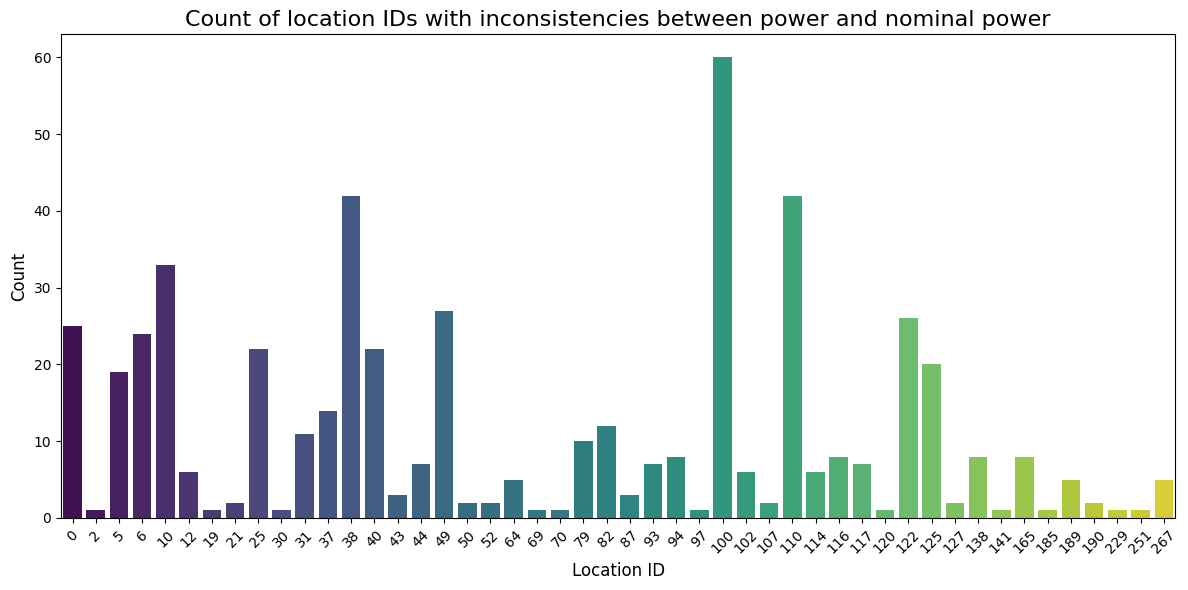

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a condition to check if any power value exceeds the nominal_power for each row
condition = df[[f'power_{i}' for i in range(40)]].gt(df['nominal_power'] +1, axis=0).any(axis=1)

# Filter the rows where at least one power value is greater than nominal_power
df_filtered = df[condition]

# Count the occurrences of each location_id in the filtered DataFrame
location_counts = df_filtered['location_id'].value_counts()

# Plotting the data
plt.figure(figsize=(12, 6))
sns.barplot(x=location_counts.index, y=location_counts.values, palette='viridis')
plt.title('Count of location IDs with inconsistencies between power and nominal power', fontsize=16)
plt.xlabel('Location ID', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# for col in [f'power_{i}' for i in range(40)]:
#     df[col] = df[col].clip(upper = df["nominal_power"])





In [ ]:
def add_temp_col(df):
  df = df.copy()
  temperature_data = {
      'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
      'temperatur': [-4, -4, 0, 5, 10, 14, 17, 15, 11, 5, 1, -3]
  }
  temp_df = pd.DataFrame(temperature_data)
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
  df['month'] = df['timestamp'].dt.month
  df = df.merge(temp_df, on='month', how='left')
  df = df.drop(columns=['month'])
  return df

df = add_temp_col(df)
df.head()


In [ ]:
# 1. Extract the month from the timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['month'] = df['timestamp'].dt.month  # Extract month from timestamp

# 2. Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' avoids the dummy variable trap

# 3. Reshape the data (encoder requires 2D array)
month_values = df['month'].values.reshape(-1, 1)

# 4. Fit and transform the data
encoded_months = encoder.fit_transform(month_values)

# 5. Create column names for the encoded months
encoded_columns = [f'month_{int(i)}' for i in encoder.categories_[0][1:]]  # Drop first category (January)

# 6. Convert the encoded months into a DataFrame
df_encoded_months = pd.DataFrame(encoded_months, columns=encoded_columns, index=df.index)

# 7. Concatenate the encoded columns to the original DataFrame
df = pd.concat([df, df_encoded_months], axis=1)

# 8. Drop the temporary 'month' column
df = df.drop(columns=['month'])

# 9. Print the updated DataFrame to verify
print(df.head())




In [75]:
train, temp = train_test_split(df, train_size=0.70, test_size=0.30, shuffle=True, random_state=42)
validation, test = train_test_split(temp, train_size=0.5, test_size=0.5, random_state=42)

In [ ]:
train.head()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(train['nominal_power'], bins=10, kde=False, color='blue')

plt.title('Distribution of Nominal Power')
plt.xlabel('Nominal Power')
plt.ylabel('Frequency')

plt.show()


In [78]:
# Define input features and target columns
INPUT_FEATURES = [f'power_{i}' for i in range(10)] + [f'soc_{i}' for i in range(10)]
INPUT_FEATURES += ["nominal_power","location_id"] # timestamp
# todo location_id should be discrete
# todo add timestamp
TARGETS = [f'power_{i}' for i in range(10, 40)]

In [79]:
# Prepare training data
X_train = train[INPUT_FEATURES]
y_train = train[TARGETS]

# Prepare validation data
X_val = validation[INPUT_FEATURES]
y_val = validation[TARGETS]

# Prepare test data
X_test = test[INPUT_FEATURES]
y_test = test[TARGETS]

In [ ]:
# Multi-output SVM
model = MultiOutputRegressor(SVR())
model.fit(X_train.iloc[:10000], y_train.iloc[:10000])
  

In [44]:
# Predict
y_pred = model.predict(X_val[:10000])

In [ ]:
mae_validation = mean_absolute_error(y_pred, y_val[:10000])

print(f'Validation MAE: {mae_validation}')

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

X_train_sample = X_train.sample(frac=0.1, random_state=42)
y_train_sample = y_train.sample(frac=0.1, random_state=42)



# Apply PCA for dimensionality reduction (optional, based on your needs)
pca = PCA(n_components=5)  # Reduce to 5 components (adjust as needed)



# Transform the input features
X_transformed = pipeline.fit_transform(X)

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('loc', OneHotEncoder(), ['location_id']),  # One-hot encode location_id
        ('num', StandardScaler(), [col for col in INPUT_FEATURES if col != 'location_id'])  # Standardize numerical features
    ])

# Apply preprocessing to training, validation, and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)  # No fitting, just transform
X_test_preprocessed = preprocessor.transform(X_test)



In [40]:

# df['hour'] = df['timestamp'].dt.hour

# plt.figure(figsize=(12, 6))
# sns.histplot(df, x='hour', weights='total_power', bins=24, kde=True)

# # Customize plot
# plt.xlabel("Hour of the Day")
# plt.ylabel("Total Power Consumption")
# plt.title("Total Power Consumption at Different Times of the Day")
# plt.xticks(range(0, 24))  # Ensure all hours are labeled
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Show plot
# plt.show()

In [41]:
# # Extract the weekday (0 = Monday, 6 = Sunday)
# df['weekday'] = df['timestamp'].dt.dayofweek

# # Map weekdays to names
# weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# df['weekday_name'] = df['weekday'].map(lambda x: weekday_names[x])

# # Aggregate total power consumption per weekday
# weekday_power = df.groupby('weekday_name')['total_power'].sum().reindex(weekday_names)  # Ensure correct order

# # Plot
# plt.figure(figsize=(10, 5))
# sns.barplot(x=weekday_power.index, y=weekday_power.values, palette='viridis')

# # Customize
# plt.xlabel("Day of the Week")
# plt.ylabel("Total Power Consumption")
# plt.title("Total Power Consumption by Weekday")
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Show plot
# plt.show()